<center>
<h2>Geometric Data Analysis</h2>
<h3>Project : Compressive K-Means</h3>
<h4><strong>Tests on artificial synthetic data</strong></h4>
<hr/>
<strong>Ben Kabongo B.</strong><br/>
Master MVA, ENS Paris-Saclay<br/>
ben.kabongo_buzangu@ens-paris-saclay.fr
<hr/>
</center>

> In this notebook, we'll carry out some initial experiments comparing K-Means (from scikit-learn) and our CKMeans implementation.

### Imports & configs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import warnings
from sklearn import datasets
from sklearn.cluster import KMeans

In [2]:
import sys
sys.path.append("../src/")
from CKMeans import CKMeans, InitMode
from frequencies import draw_frequencies, FrequencyType
from sketching import Sk
from utils import SSE, compute_scores, predict_labels

In [3]:
warnings.filterwarnings(action="ignore")
plt.style.use("bmh")
np.random.seed(42)
random.seed(42)

## 2D Toys datasets

In [4]:
n = 100

In [5]:
data_blobs, labels_blobs = datasets.make_blobs(n_samples=n, centers=3, random_state=42)
data_moons, labels_moons = datasets.make_moons(n_samples=n, noise=0.05, random_state=42)
data_circles, labels_circles = datasets.make_circles(n_samples=n, factor=0.5, noise=0.05, random_state=42)

all_datasets = [(data_blobs, labels_blobs), (data_moons, labels_moons), (data_circles, labels_circles)]

In [6]:
def plot_datasets(datasets):
    n = len(datasets)
    plt.figure(figsize=(5 * n, 4))
    for i, (X, true_labels) in enumerate(datasets, 1):
        plt.subplot(1, n, i)
        plt.scatter(X[:, 0], X[:, 1], c=true_labels, edgecolor="k", s=20)
        plt.title(f"Dataset {i}")
    plt.show()

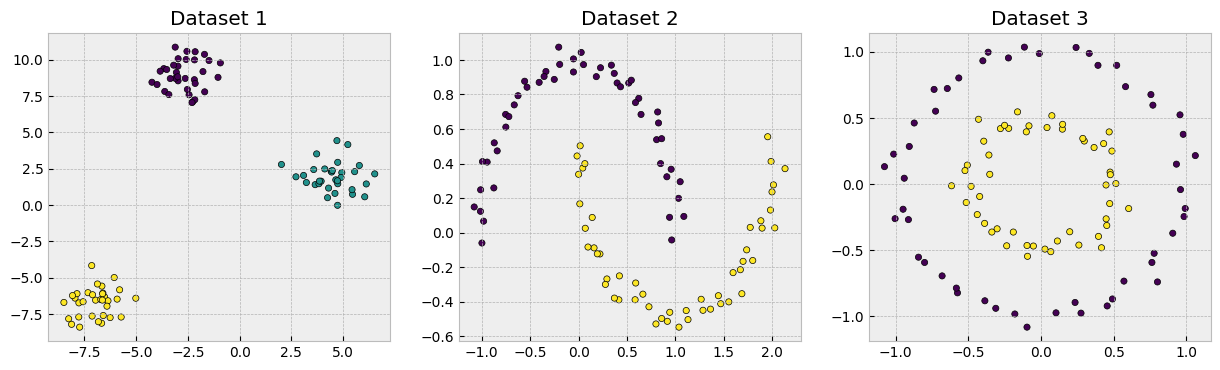

In [7]:
plot_datasets(all_datasets)

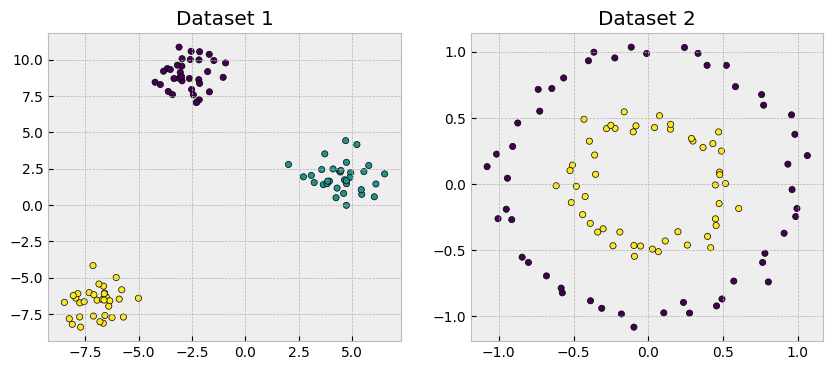

In [8]:
select_datasets = [all_datasets[0], all_datasets[2]]
plot_datasets(select_datasets)

### K-Means

In [9]:
def kmeans_2D(datasets):
    n = len(datasets)
    plt.figure(figsize=(5 * n, 4))
    for i, (X, true_labels) in enumerate(datasets, 1):
        kmeans = KMeans(len(np.unique(true_labels)), n_init="auto")
        kmeans.fit(X)
        C = kmeans.cluster_centers_
        predicted_labels = kmeans.labels_

        scores = compute_scores(true_labels, predicted_labels)
        scores["SSE/N"] = kmeans.inertia_/len(X)
        rand_index = scores["ARI"]

        print(f"Dataset {i}")
        print("".join(f"{metric_name + ' '*(8-len(metric_name))}\t: {value:.2f}\n" for metric_name, value in scores.items()))
        plt.subplot(1, n, i)
        plt.scatter(X[:, 0], X[:, 1], c=predicted_labels, cmap='viridis', edgecolor='k', s=20)
        plt.scatter(C[:, 0], C[:, 1], c='red', marker='o', s=50, label='Centroids')
        plt.title(f"Dataset {i} \nAdjusted Rand Index: {rand_index:.2f}\nSSE/N: {(kmeans.inertia_/len(X)):.2f}")
        plt.legend()

    plt.show()

Dataset 1
ARI     	: 1.00
AMI     	: 1.00
homogeneity	: 1.00
completeness	: 1.00
v-measure	: 1.00
SSE/N   	: 1.72

Dataset 2
ARI     	: 0.26
AMI     	: 0.20
homogeneity	: 0.20
completeness	: 0.20
v-measure	: 0.20
SSE/N   	: 0.41

Dataset 3
ARI     	: -0.01
AMI     	: -0.01
homogeneity	: 0.00
completeness	: 0.00
v-measure	: 0.00
SSE/N   	: 0.40



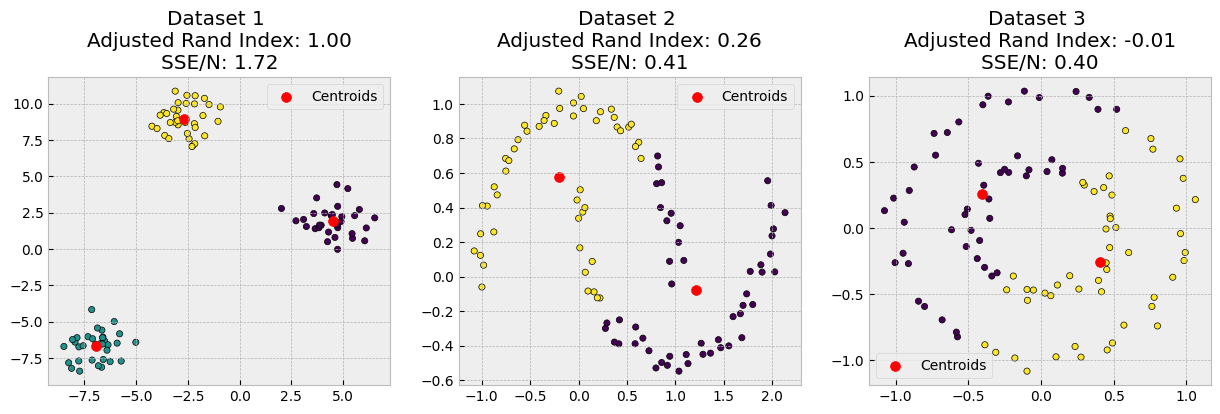

In [10]:
kmeans_2D(all_datasets)

Dataset 1
ARI     	: 1.00
AMI     	: 1.00
homogeneity	: 1.00
completeness	: 1.00
v-measure	: 1.00
SSE/N   	: 1.72

Dataset 2
ARI     	: -0.01
AMI     	: -0.01
homogeneity	: 0.00
completeness	: 0.00
v-measure	: 0.00
SSE/N   	: 0.40



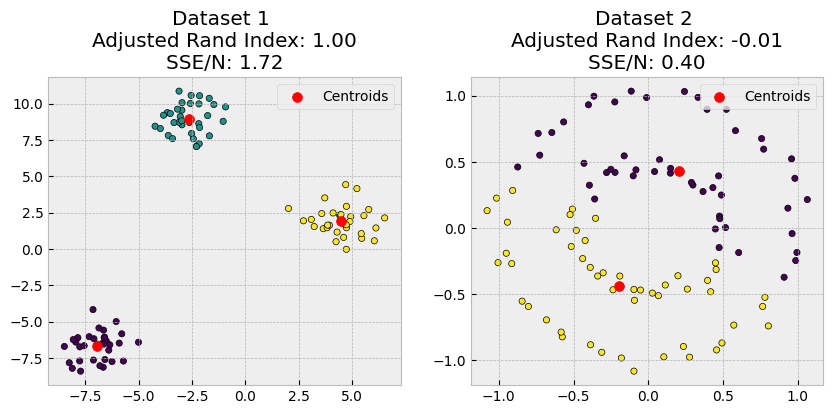

In [11]:
kmeans_2D(select_datasets)

#### Limitations of K-Means

We note that the K-Means algorithm has limitations, particularly when clustering data with real clusters nested inside each other.

#### SSE good metric ?

Very often, when clustering, we don't have the labels of the data we want to divide into clusters. The idea behind clustering is that data can be distributed according to their labels, in this case synonymous with similarity.

In the various toy examples above, we have the labels of the examples. We use the adjusted rank score and sse metrics.

From the point of view of the labels, the clusterings obtained for datasets 2 and 3 are not correct. They have adjusted rand scores very close to zero, but have smaller SSE scores than the clustering of dataset 1, which has an adjusted rand score of 1.

This could raise questions about the quality of SSE as a metric for evaluating good clustering.

### CKM

Dataset 1
ARI     	: 0.49
AMI     	: 0.61
homogeneity	: 0.56
completeness	: 0.69
v-measure	: 0.61
SSE/N   	: 7.86

Dataset 2
ARI     	: 0.00
AMI     	: 0.00
homogeneity	: 0.00
completeness	: 1.00
v-measure	: 0.00
SSE/N   	: 1.33

Dataset 3
ARI     	: -0.01
AMI     	: -0.01
homogeneity	: 0.00
completeness	: 0.00
v-measure	: 0.00
SSE/N   	: 0.75



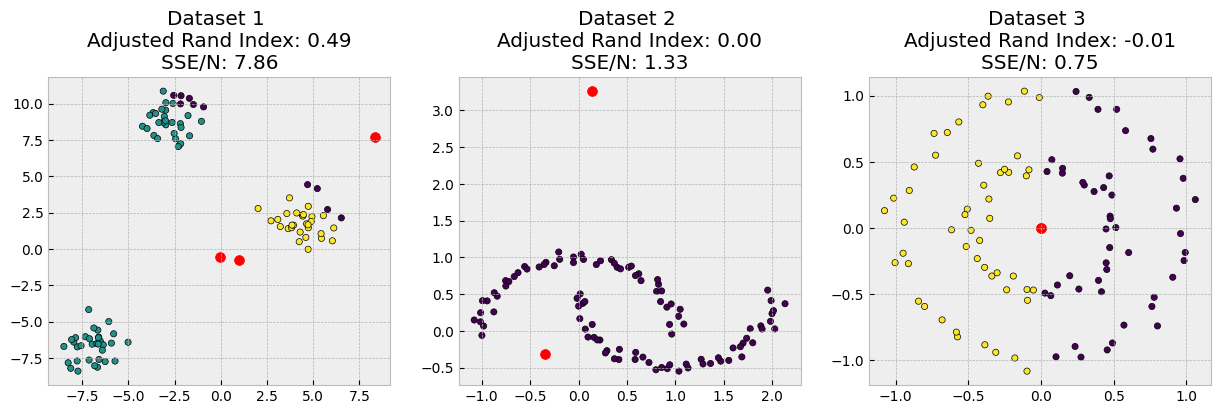

In [12]:
plt.figure(figsize=(15, 4))
for i, (X, true_labels) in enumerate(all_datasets, 1):
    d = 2
    K = len(np.unique(true_labels))
    N = len(X)
    l = np.min(X) * np.ones(d)
    u = np.max(X) * np.ones(d)

    # frequencies
    m = K * N
    m0 = m
    c = 10
    n0 = N // 10
    display = False

    R = np.random.random(c)
    T = N // 10
    Omega = draw_frequencies(X, m, n0, m0, c, T, R, FrequencyType.GAUSSIAN, display)

    # sketching
    z = Sk(Omega, X)

    # CKMeans
    C, alpha = CKMeans(z, Omega, K, l, u, X, InitMode.RANGE, display)
    predicted_labels = predict_labels(X, C)

    sse = SSE(X, C) / N
    scores = compute_scores(true_labels, predicted_labels)
    scores["SSE/N"] = sse
    rand_index = scores["ARI"]

    print(f"Dataset {i}")
    print("".join(f"{metric_name + ' '*(8-len(metric_name))}\t: {value:.2f}\n" for metric_name, value in scores.items()))
    plt.subplot(1, 3, i)
    plt.scatter(X[:, 0], X[:, 1], c=predicted_labels, cmap='viridis', edgecolor='k', s=20)
    plt.scatter(C[:, 0], C[:, 1], c="red", marker='o', s=50)
    plt.title(f"Dataset {i} \nAdjusted Rand Index: {rand_index:.2f}\nSSE/N: {sse:.2f}")

plt.show()

### Dataset 1 : CKM

In [13]:
N = 10_000
X, true_labels = datasets.make_blobs(n_samples=N, centers=3, random_state=42)

In [14]:
colors = list(map(lambda i: ["#48cae4", "#2ecc71", "#ff7b94"][i], true_labels))

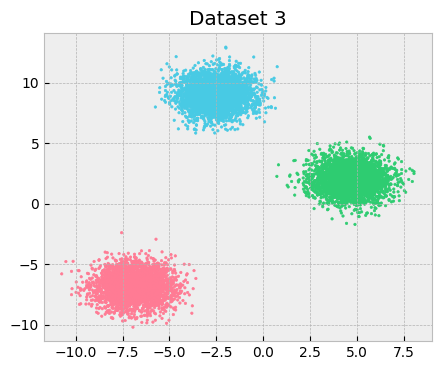

In [15]:
plt.figure(figsize=(5, 4))
plt.subplot(1, 1, 1)
plt.scatter(X[:, 0], X[:, 1], c=colors, s=3, edgecolors=colors)
plt.title(f"Dataset {i}")
plt.show()

In [16]:
d = 2
K = 3

l = np.min(X) * np.ones(d)
u = np.max(X) * np.ones(d)

m_factor_list = np.arange(1, 5)

all_scores                 = {}
all_scores["ARI"]          = []
all_scores["AMI"]          = []
all_scores["homogeneity"]  = []
all_scores["completeness"] = []
all_scores["v-measure"]    = []
all_scores["SSE/N"]        = []

for m_factor in m_factor_list:
    # frequencies
    m = m_factor * K * N
    m0 = m
    n0 = N // 100
    display = False
    c = m // 10
    R = np.random.random(c)
    T = 10
    Sigma = 0.5 * np.identity(d)
    Omega = draw_frequencies(X, m, n0, m0, c, T, R, FrequencyType.GAUSSIAN, display)

    # sketching
    z = Sk(Omega, X)

    # CKMeans
    C, alpha = CKMeans(z, Omega, K, l, u, X, InitMode.RANGE, display)
    predicted_labels = predict_labels(X, C)

    sse = SSE(X, C) / N
    scores = compute_scores(true_labels, predicted_labels)
    scores["SSE/N"] = sse

    for score_name, score in scores.items():
        all_scores[score_name].append(score)


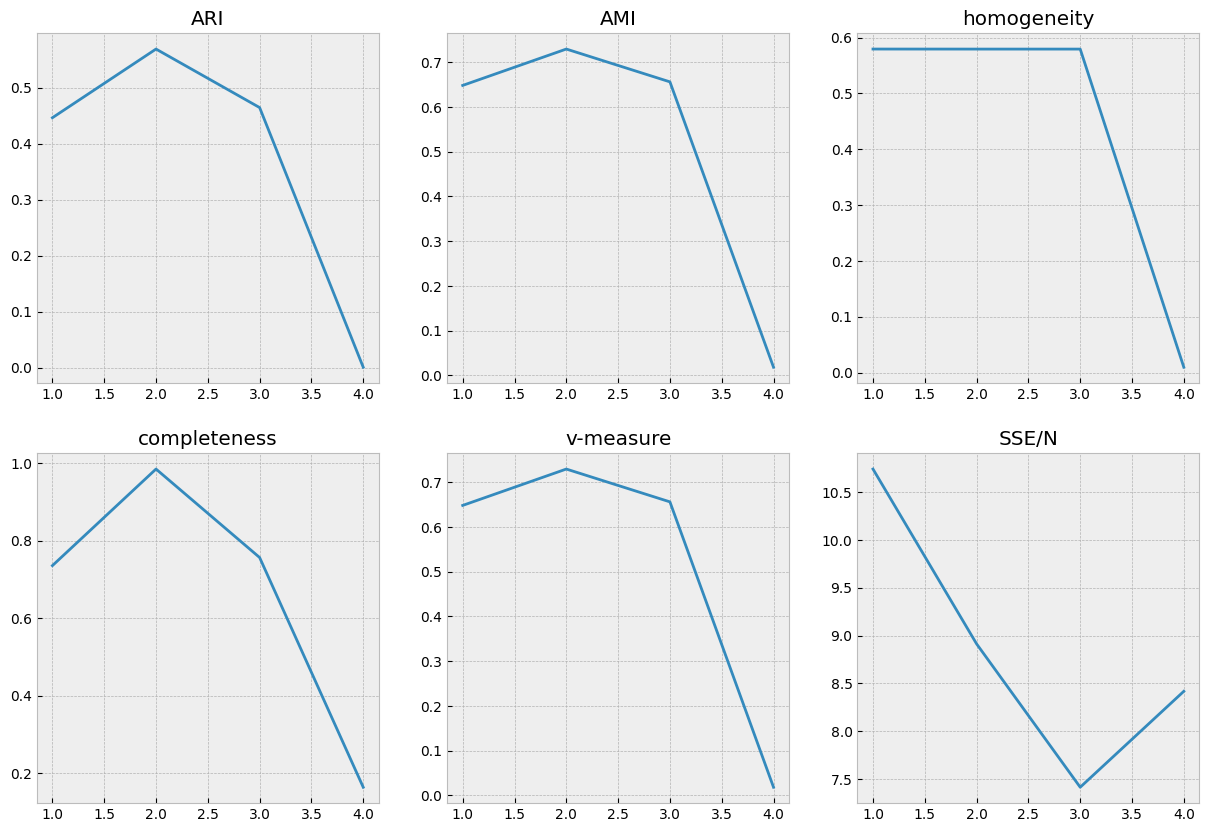

In [17]:
plt.figure(figsize=(15, 10))
for i, (score_name, scores) in enumerate(all_scores.items(), 1):
    plt.subplot(2, 3, i)
    plt.plot(m_factor_list, scores)
    plt.title(score_name)
plt.show()

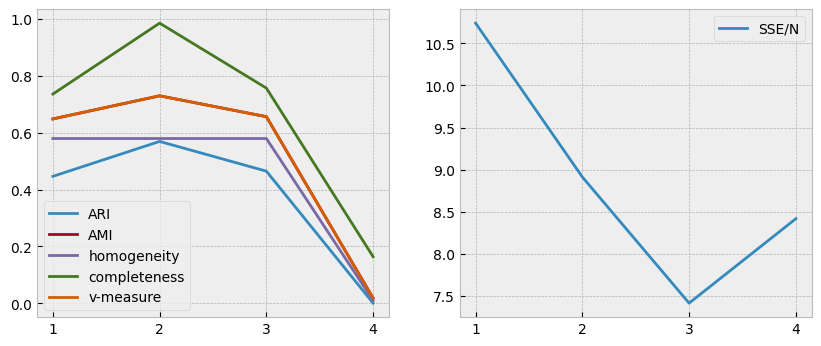

In [18]:
plt.figure(figsize=(10, 4))
for (score_name, scores) in all_scores.items():
    if score_name == "SSE/N": continue
    plt.subplot(1, 2, 1)
    plt.plot(m_factor_list, scores, label=score_name)
    plt.xticks(m_factor_list)
    plt.legend()
plt.subplot(1, 2, 2)
plt.plot(m_factor_list, all_scores["SSE/N"], label="SSE/N")
plt.xticks(m_factor_list)
plt.legend()
plt.show()

In [19]:
print(all_scores["SSE/N"])
np.argmin(all_scores["SSE/N"]) + 1

[10.74043790694282, 8.912764109101072, 7.414372710536518, 8.417260078372474]


3

ARI     	: 0.48
AMI     	: 0.53
homogeneity	: 0.43
completeness	: 0.70
v-measure	: 0.53
SSE/N   	: 7.21



Text(0.5, 1.0, '\nAdjusted Rand Index: 0.48\nSSE/N: 7.21')

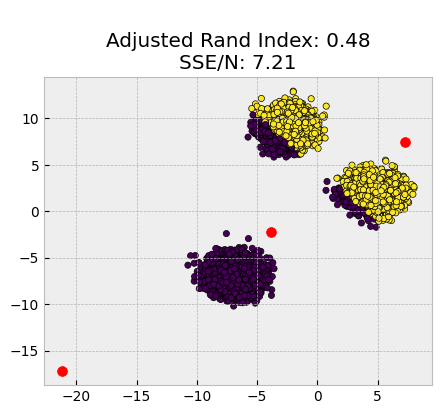

In [20]:
d = 2
K = 3

l = np.min(X) * np.ones(d)
u = np.max(X) * np.ones(d)

# frequencies
m = 3 * K * N
m0 = m
n0 = N // 100
display = False
c = m // 10
R = np.random.random(c)
T = 10
Sigma = 0.5 * np.identity(d)
Omega = draw_frequencies(X, m, n0, m0, c, T, R, FrequencyType.GAUSSIAN, display)

# sketching
z = Sk(Omega, X)

# CKMeans
C, alpha = CKMeans(z, Omega, K, l, u, X, InitMode.RANGE, display)
predicted_labels = predict_labels(X, C)

sse = SSE(X, C) / N
scores = compute_scores(true_labels, predicted_labels)
scores["SSE/N"] = sse
rand_index = scores["ARI"]

print("".join(f"{metric_name + ' '*(8-len(metric_name))}\t: {value:.2f}\n" for metric_name, value in scores.items()))
plt.figure(figsize=(5, 4))
plt.scatter(X[:, 0], X[:, 1], c=predicted_labels,cmap='viridis', edgecolor='k', s=20)
plt.scatter(C[:, 0], C[:, 1], c="red", marker='o', s=50)
plt.title(f"\nAdjusted Rand Index: {rand_index:.2f}\nSSE/N: {sse:.2f}")


In [21]:
print(C)

[[-21.20431438 -17.21826987]
 [ -3.83360234  -2.187663  ]
 [  7.25976668   7.47723453]]
